# Deep Learning: II

*Davide Gerosa (Milano-Bicocca)* 

##### Reading/watching

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 9.
- [Neural Networks Demystified](https://www.youtube.com/watch?v=bxe2T-V8XRs&list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU&ab_channel=WelchLabs) youtube playlist.

##### Dig deeper:

- ["Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow", Aurelien Geron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/). 
-  ["Neural Networks and Deep Learning"](http://neuralnetworksanddeeplearning.com/index.html). Free online book!
- Many many blogs and videos. Deep learning as a million applications that go well beyond astrophysics. There is truly excellent content accessibile out there with just a tiny bit of googling.

This course is based on previous work by many people. See [here]((https://github.com/dgerosa/astrostatistics_bicocca_2023/blob/main/README.md) for credits.

---

Before starting today, let's install the two big Deep Learning packages out there. [Tensorflow](https://www.tensorflow.org/) and [PyTorch](https://pytorch.org/)-- the rivalry essentially boils down to Google versus Facebook. These are the public deep learning implementation of giant companies.

In general, I find TensorFlow more customizable and there are excellent tutorials around! Tensorflow is somewhat less readable while coding in Pytorch is a more "pythonic" experience (some operations feel more natural). But it's really a matter of taste here... In my research group we joined the Google camp and use TensorFlow. 


In [1]:
!pip install --upgrade pip

#### Tensorflow

In [2]:
!pip3 install tensorflow

#### PyTorch

In [3]:
!pip3 install torch torchvision

#### Keras

**[Keras](https://keras.io/)** is a deep learning API. Essentially it is Scikit-Learn for deep neural networks.

Keras needs a computational backend to handle the heavy computation.  Three popular (open sources) deep learning libraries are [TensorFlow](https://www.tensorflow.org/), Microsoft Cognitive Toolkit, and [Theano](http://www.deeplearning.net/software/theano/). TensorFlow now comes bundled with a version of Keras and that's what we'll use here (actually TensorFlow 2). PyTorch is another option. If you apply for a data-science job in industry knowing one of these tools might be the most useful thing for you to have learned.

In short, for neural networks:

> numpy -> tensorflow

> sklearn -> keras

In the same way that you can build a linear regression algorithm in numpy without using sklearn, you can build a neural network algorithm (not to mention linear regression) in tensorflow without using keras.  But just as sklearn makes our life easier, so too does keras.


Crucially, these libraries work with automatic differentiation. We won't call the autodiff modules explicitely but they are [tensorflow.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) and [torch.autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).


## Photo-z with deep learning <a class="anchor" id="one"></a>

An important problem in galaxy imaging is being able to use observed galaxy color data to estimate its redshift. This is sometimes called "photo-z". Now, on your humble computer, you will build a deep neural network that is trained on a sample of SDSS galaxy color data. You'll see that `pytorch` makes this quite easy.

In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

from astroML.datasets import fetch_sdss_specgals
from astroML.utils.decorators import pickle_results

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

Read in and prepare the SDSS data.

In [5]:
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes into array
# normalize to zero mean and unit variance for easier training
datanormed = np.zeros((len(data), 6), 
                      dtype=np.float32)
for i, band in enumerate(['u', 'g', 'r', 'i', 'z']):
    band = 'modelMag_' + band
    datanormed[:, i] = ((data[band] - data[band].mean()) / 
                        data[band].std())

# put redshifts into array
datanormed[:, 5] = data['z']

Let's define a little helper class that will make our network. It is initialized with a given number of neurons in the single hidden layer. These neurons in the hidden layer connect to $5$ input variables (colors) and spits out 1 variable (redshift). You can also see that it uses ReLU activation for the neurons.

In [6]:
# define structure of neural net
class Net(nn.Module):
    def __init__(self, nhidden):
        super(Net, self).__init__()
        self.fc_h = nn.Linear(5, nhidden)
        self.fc_o = nn.Linear(nhidden, 1)

    def forward(self, x):
        h = F.relu(self.fc_h(x))
        z = self.fc_o(h)
        return z

Do a train-test split on the data.

In [7]:
# split data into 9:1 train:test
dataset = torchdata.TensorDataset(torch.tensor(datanormed[:, 0:5]),
                                  torch.tensor(datanormed[:, 5]).view(-1, 1))
trainnum = datanormed.shape[0] // 10 * 9
traindata, testdata = torchdata.random_split(dataset, 
                                             [trainnum, datanormed.shape[0] - trainnum])
traindataloader = torchdata.DataLoader(traindata, 
                                       batch_size=128, 
                                       shuffle=True)

Define a function to train the neural network. This looks like a lot of code, but the first block is the key. The network will have $4$ neurons in the hidden layer, and will use stochastic gradient descent to train the weights and biases.

In [8]:
@pickle_results('NNphotoz.pkl')
def train_NN():
    # 4 hidden layers
    model = Net(4)
    # MSE loss
    criterion = torch.nn.MSELoss(reduction='sum') 
    # stochastic gradient descent
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001) 
    # Adaptive learning rate...
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           verbose=True, 
                                                           patience=5, 
                                                           threshold=1e-3)

    min_valid_loss = float('inf')
    badepochs = 0
    for t in range(100):
        train_loss = 0
        for i, databatch in enumerate(traindataloader, 0):
            photometry, redshifts = databatch
            optimizer.zero_grad()
            z_pred = model(photometry)
            loss = criterion(z_pred, redshifts)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        with torch.no_grad():
            photometry = testdata[:][0]
            redshifts = testdata[:][1]
            z_pred = model(photometry)
            valid_loss = criterion(z_pred, redshifts)
            if t % 10 == 0:
                print('Epoch %3i: train loss %0.3e validation loss %0.3e' % (t, \
                        train_loss / len(traindata), valid_loss / len(testdata)))
            # stop training if validation loss has not fallen in 10 epochs
            if valid_loss > min_valid_loss*(1-1e-3):
                badepochs += 1
            else:
                min_valid_loss = valid_loss
                badepochs = 0
            if badepochs == 10:
                print('Finished training')
                break
        scheduler.step(valid_loss)
    return model

Let's train this thing. It should take about five minutes. 

In [9]:
model = train_NN()

@pickle_results: using precomputed results from 'NNphotoz.pkl'


In [10]:
print(model)

Net(
  (fc_h): Linear(in_features=5, out_features=4, bias=True)
  (fc_o): Linear(in_features=4, out_features=1, bias=True)
)


Plot the results.

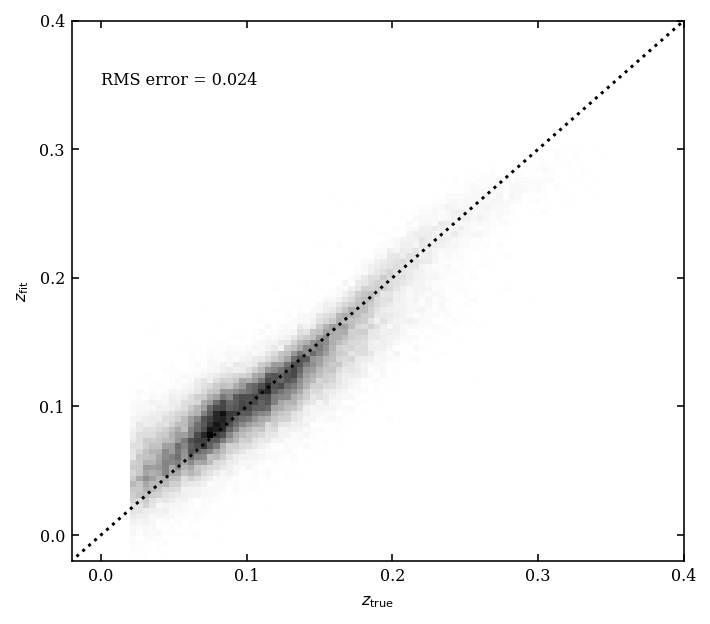

In [11]:
# plot the results
with torch.no_grad():
    photometry = testdata[:][0]
    redshifts = testdata[:][1]
    z_pred = model(photometry)
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(wspace=0.25,
                        left=0.1, right=0.95,
                        bottom=0.15, top=0.9)

    ax = plt.axes()
    H, zs_bins, zp_bins = np.histogram2d(redshifts.numpy().flatten(), 
                                         z_pred.numpy().flatten(), 151)
    ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
               extent=[zs_bins[0], zs_bins[-1], zp_bins[0], zp_bins[-1]],
               cmap=plt.cm.binary)
    ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
    rms = np.sqrt(np.mean((z_pred-redshifts).numpy()**2))
    
    ax.text(0, 0.35, 'RMS error = %0.3f' % np.sqrt(np.mean((z_pred-
                                                            redshifts).numpy()**2)))
    ax.set_xlim(-0.02, 0.4001)
    ax.set_ylim(-0.02, 0.4001)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    
    ax.set_xlabel(r'$z_{\rm true}$')
    ax.set_ylabel(r'$z_{\rm fit}$')
    
    plt.show()

Not bad at all! Still, this was a relatively simple fully-connected network. Other problems will require more complexity...

## Another multilayer perceptron example

Let's go back to the dataset we used last week, when we classified gravitational-wave sources based on their LIGO detectability. I had previously tackled this problem using a multi-layer perceptron: https://arxiv.org/abs/2007.06585. This was implemented using TensorFlow

In [12]:
import deepdish
import os
import tensorflow as tf
from tensorflow import keras


def sperical_to_cartesian(mag,theta,phi):
    '''
    Convert spherical to cartesian coordinates
    '''
    coordx = mag * np.cos(phi) * np.sin(theta)
    coordy = mag * np.sin(phi) * np.sin(theta)
    coordz = mag * np.cos(theta)
    return coordx,coordy,coordz

massvar = ['mtot','q','z']
spinvar = ['chi1x','chi1y','chi1z','chi2x','chi2y','chi2z']
intrvar=massvar+spinvar
extrvar = ['iota','ra','dec','psi']
train_variables=intrvar+extrvar

def lookup_limits():
    '''
    Define the limits in all variables. If you want to change this, please check generate_binaries() and pdet() as well.
    '''

    limits={
        'mtot'  : [2,1000],
        'q'     : [0.1,1],
        'z'     : [1e-4,4],
        'chi1x'  : [-1,1],
        'chi1y'  : [-1,1],
        'chi1z'  : [-1,1],
        'chi2x'  : [-1,1],
        'chi2y'  : [-1,1],
        'chi2z'  : [-1,1],
        'iota'  : [0,np.pi],
        'ra'    : [-np.pi,np.pi],
        'dec'   : [-np.pi/2,np.pi/2],
        'psi'   : [0,np.pi]
        }

    return limits


def store_binaries(filename, N, approximant='IMRPhenomXPHM', noisecurve='design', SNRthreshold=12):
    ''' Generate binaries, compute SNR, and store'''

    inbinaries = generate_binaries(N)
    outbinaries = evaluate_binaries(inbinaries, approximant, noisecurve, SNRthreshold)

    deepdish.io.save(filename,outbinaries)
    return filename

def readsample(filename='sample.h5'):
    '''
    Read a validation sample that already exists
    '''
    return deepdish.io.load(filename)

def splittwo(binaries):
    '''
    Split sample into two subsamples of equal size
    '''

    one={}
    two={}
    for k in train_variables+['snr','det']:
        one[k],two[k] = np.split(binaries[k],2)
    one['N'],two['N']= len(one['mtot']),len(two['mtot'])

    return one,two


def rescale(x,var):
    '''
    Rescale variable sample x of variable var between -1 and 1
    '''

    limits=lookup_limits()
    if var not in limits:
        raise ValueError

    return 1-2*(np.array(x)-min(limits[var]))/(max(limits[var])-min(limits[var]))


def nnet_in(binaries):
    '''
    Prepare neural network inputs.
    '''

    return np.array([rescale(binaries[k],k) for k in train_variables]).T

def nnet_out(binaries, which='detnetwork'):
    '''
    Prepare neural network outputs.
    '''

    return binaries['det']


def trainnetwork(train_binaries,test_binaries,filename='trained.h5'):

    if not os.path.isfile(filename):

        train_in  = nnet_in(train_binaries)
        train_out = nnet_out(train_binaries)
        test_in  = nnet_in(test_binaries)
        test_out = nnet_out(test_binaries)

        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=1)
        # Define neural network architecture
        model = keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            # Inner layers, can add/change
            keras.layers.Dense(32,  activation='tanh',kernel_initializer=my_init),
            #keras.layers.Dense(16,  activation='tanh',kernel_initializer=my_init),
            #keras.layers.Dense(8,  activation='tanh',kernel_initializer=my_init),
            # Output layer, do not change
            keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])

        model.compile(
            # Optimization algorithm, specify learning rate
            optimizer=keras.optimizers.Adam(learning_rate=1e-2),
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])

        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * tf.math.exp(-0.05)

        # Actual Training
        history = model.fit(
            # Training inputs
            train_in,
            # Training outputs
            train_out,
            # Evaluate test set at each epoch
            validation_data=(test_in, test_out),
            # Batch size, default is 32
            #batch_size=32,
            # Number of epochs
            epochs=150,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs"+filename.split('.h5')[0], histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

        # Store the last (not necessarily the best) iteration
        #model.save(filename)

    model = loadnetwork(filename)
    return model


def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model


def testnetwork(model,binaries):
   '''
   Test network on a series of binaries
   '''
   test_in  = nnet_in(binaries)
   test_out = nnet_out(binaries)
   model.evaluate(test_in,  test_out, verbose=2)


def predictnetwork(model, binaries):
    '''
    Use a network to predict the detectability of a set of binaries.
    '''
    # Return the class (0 or 1) that is preferred
    predictions = np.squeeze((model.predict(nnet_in(binaries)) > 0.5).astype("int32"))
    return predictions


2023-05-18 12:40:38.615864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Load sample
binaries= readsample('/Users/dgerosa/Downloads/sample_2e7_design_precessing_higherordermodes_3detectors.h5')

In [14]:
# Split test/training
train_binaries,test_binaries=splittwo(binaries)

In [15]:
# Train a neural network
trainnetwork(train_binaries,test_binaries,filename='trained.h5')

AttributeError: 'Config' object has no attribute 'keys'

In [16]:
# That's going to take ~12 hours on this laptopt (I don't have a GPU turned on...). Here is the trained file:
# https://github.com/dgerosa/pdetclassifier/blob/master/trained_2e7_design_precessing_higherordermodes_3detectors.h5

import requests
url = 'https://github.com/dgerosa/pdetclassifier/blob/master/trained_2e7_design_precessing_higherordermodes_3detectors.h5?raw=true'
r = requests.get(url, allow_redirects=True)
open('trained_2e7_design_precessing_higherordermodes_3detectors.h5', 'wb').write(r.content)


29608

In [17]:
import tensorflow as tf

# Load trained network
model = loadnetwork('trained_2e7_design_precessing_higherordermodes_3detectors.h5')

In [18]:
# Some downsampling, otherwise the evaluation takes to long for class
test_less={}
for k in ['mtot', 'q', 'z', 'chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'iota', 'ra', 'dec', 'psi', 'snr', 'det']:
    test_less[k]=test_binaries[k][:100]

In [19]:
testnetwork(model,test_less)

4/4 - 0s - loss: 0.0682 - accuracy: 0.9800 - 355ms/epoch - 89ms/step


In [20]:
predictnetwork(model, test_less)

4/4 [==============================] - 0s 2ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], dtype=int32)

## Convolutional Neural Networks (CNNs) <a class="anchor" id="two"></a>

Recent interest in neural networks surged in 2012 when a team using a deep **[convolutional neural network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network)** acheived record results classifying objects in the [ImageNet](http://image-net.org/) data set.

If you naively apply a multi-layer perceptron to an image, the first thing to do would be unravel the array of pixels into a long one-dimensional array (much like we did for the digits images a few weeks ago). That's fine but it's neglecting precious information, namely that pixels next to each other are correlated.

The idea behind CNNs is inspired by human visual perception. ***Each neuron in your visual cortex doesn't "see" all of what your eye can see at once*** and some neurons are more sensitive to one pattern over another (e.g., horizontal lines vs. vertical lines).  

Moreover, the simplest deeply connected neural networks would choke on "real" data which has far more than 28x28 pixels, and would require following tens of millions of connections. So we use a combination of 
- "convolution"
- "pooling" 

to reduce the dimensionality of the data first.

![Ivezic Figure 9.19](https://www.astroml.org/_images/fig_cnn_1.png)

### Convolutional Layers

In a convolutional layer, each neuron is not connected to each neuron in the previous layer, but only those that are within its "field of view" as defined by a kernel (filter).  We slide the kernel over the input layer and the value in the next layer depends only on those pixels.

![](https://miro.medium.com/max/4800/1*GcI7G-JLAQiEoCON7xFbhg.gif)

Here's another perspective that helps to visualize going from one layer to the next.

![Convolution example](https://docs-assets.developer.apple.com/published/09348c5368/a55b1477-4f79-4221-8aa1-ab3ae9f01f89.png)

Choosing a filter (kernel) with a certain pattern can help recognize certain types of features (like horizontal aor vertical lines).

![vertical filter](https://miro.medium.com/max/1338/1*7IEbBib7Yc7qST5IGQoYXA.jpeg)

![horizontal filter](https://miro.medium.com/max/1238/1*PSSAaH2pZbl5bK3Ef_zk4A.jpeg)

The purpose of the convolutional layers is really to capture high-level features in the images, like edges. 


This reminds me of polarized light, which is personally how I visualized CNN in my mind...




### Pooling Layers

It is common to follow the convolutional layer by a so-called "pooling layer", essentially to reduce the amount of data that needs to be processed.  The full architechture of a CNN might look something like this:

![CNN Example](https://www.researchgate.net/publication/331986593/figure/fig1/AS:740548759547904@1553571991001/The-classic-structure-of-CNN-it-consists-of-two-modules-Feature-extraction-module-FEM.ppm)

Where the pooling layers are reducing the number of pixels by averaging, summing, taking the max, etc. "**Max Pool**" is the most popular, and literally corresponds to taking the maximum of the convolution.

![Pooling example](https://miro.medium.com/max/1000/1*ydNsGDxMldAiq7b96GDQwg.jpeg)

or another way to see this is...

![](https://miro.medium.com/max/792/1*uoWYsCV5vBU8SHFPAPao-w.gif)

When we are done with convolution and pooling, the output gets fed into a regular, fully connected neural network that outputs the predictions.

- This is clearly much more sophisticated than our basic fully-connected multi-layer perceptron. "Deep" networks consist of tens of layers with thousands of neurons. **These large networks have become usable thanks to two breakthroughs: the use of sparse layers, and the power of graphics processing units (GPUs).**


- Sparse layers or convolutional layers in a deep network contain a large number of hidden nodes but very few synapses. The sparseness arises from the relatively small size of a typical convolution kernel (15x15 is a large kernel), so a hidden node representing one output of the convolution is connected to only a few input nodes. Compare this the our previous perceptron, in which every hidden node was connected to every input node.


- Even though the total number of connections is greatly reduced in the sparse layers, the total number of nodes and connections in a modern deep network is still enormous. Luckily, training these networks turns out to be a great task for GPU acceleration.


For further study, there are lots of resources for CNNs online.  For example, see
https://medium.com/analytics-vidhya/convolutional-neural-networks-cnn-explained-step-by-step-69137a54e5e7

The following cells are from Geron, Chapter 10, see 
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

We'll start by introducing the **Fashion MNIST data set**. The next cells load the data, define test, trainging, and validation sets; normalize the data; display an example image; list the possible target values ($y$), and show a 4x10 grid of examples.

In [21]:
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(X_train_full.shape)
print(X_test.shape)

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(55000, 28, 28)
(5000, 28, 28)
(10000, 28, 28)


This data set is a huge collection of images of items of clothing.

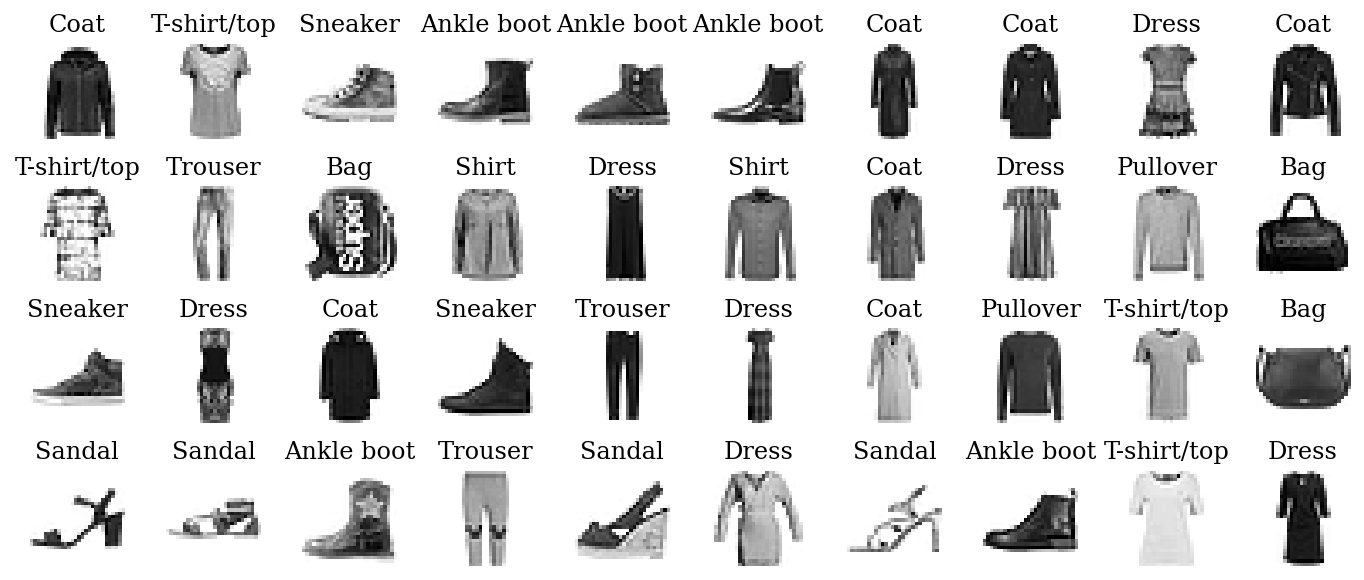

In [22]:
# Let's make a list of class names that we can refer to.
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Plot 4x10 array of images from the Fashion MNIST database
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest", origin='upper')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

We'll use `tensorflow` on this data set, through it's handy API `keras`. Since these are images and we want to preserve contextual information like edges, we'll build a CNN.

In [23]:
import tensorflow as tf

keras.backend.clear_session() # Make sure that we are starting a new model and not adding to an earlier one
np.random.seed(42) # Set the numpy and tensorflow random seeds so that we all get the same answer
tf.random.set_seed(42)

Normalize and prepare the data to pass into a network.

In [24]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std


# Need to reshape for CNN
X_train = X_train[:, :, :, np.newaxis]
X_valid = X_valid[:,  :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

print(len(X_train))
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

55000
(55000, 28, 28, 1)
(5000, 28, 28, 1)
(10000, 28, 28, 1)


The next cell looks like a lot, but really it is just a sequential declaration of different types of layer in the network. It is a combination of **2D Convolution layers** (feature finding), **Max Pooling layers** (data reduction), folloed by some **Dense layers** (fully-connected layers at the end of the network for classification) and some **Dropout** incorporated to strengthen the overall network and make sure all the neurons are actually pulling their weight.

In [25]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[28, 28, 1]),
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),  
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])   

In [26]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         2

**That's right...your CNN has ~1.5 million parameters that you are going to try to optimize on your machine...**

We'll only go through one epoch of optimization, but hopefully that will be enough to get us above $50\%$ accuracy.

In [27]:
#### This may take a while! Hopefully no more than 5 minutes for 1 epoch.
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
clf = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

1719/1719 [==============================] - 215s 123ms/step - loss: 0.7248 - accuracy: 0.7463 - val_loss: 0.3764 - val_accuracy: 0.8638


In [40]:
# Evaluate the test set
model.evaluate(X_test, y_test)

313/313 [==============================] - 9s 30ms/step - loss: 0.4068 - accuracy: 0.8511


[0.40675055980682373, 0.8511000275611877]

Predict values for first 3 test objects

In [29]:
X_new = X_test[:3]
y_proba = model.predict(X_new).round(2)
print(y_proba)

[[0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.99]
 [0.   0.   0.97 0.   0.   0.   0.03 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


So, you can see that the output is a probability that the object belongs to each class (which has to sum to 1 across all the classes).  If we just want an "answer", we assign it to the class with the highest probability (done here with `predict_classes`).

In [30]:
y_pred = np.argmax(model.predict(X_new), axis=-1) #New way
print(y_pred)
print(np.array(class_names)[y_pred])

[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']


Let's plot those and see if the predictions make sense.

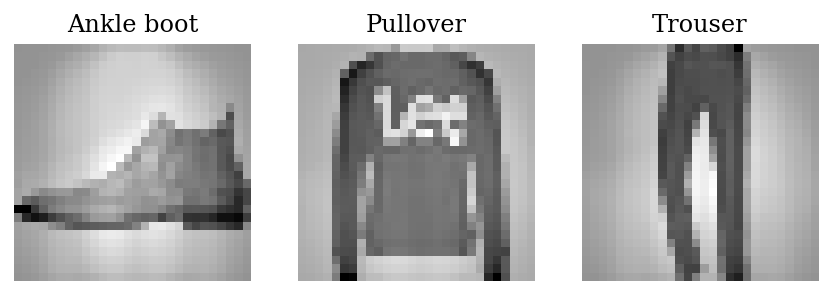

In [31]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Note that after you fit your model, you can save it and reload it at some later time (which is good because some models might take hours or days to train!)

In [32]:
# Save model
model.save("my_keras_model.h5")

# Reload model
model = keras.models.load_model("my_keras_model.h5")

Let's predict the values for 10 random objects. Display them with their actual labels first, then predict and display the predictions.

In [33]:
idx10 = np.random.choice(np.arange(len(y_test)), size=10, replace=False)
X_new = X_test[idx10]
y_pred = np.argmax(model.predict(X_new), axis=-1)

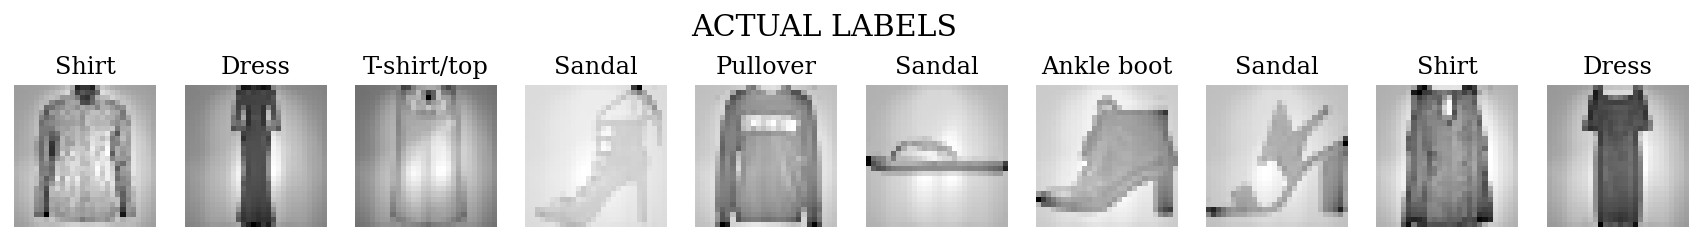

In [34]:
#Correct answers (y_test)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[idx10[index]]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.suptitle('ACTUAL LABELS',y=0.7,fontsize=15)
plt.show()

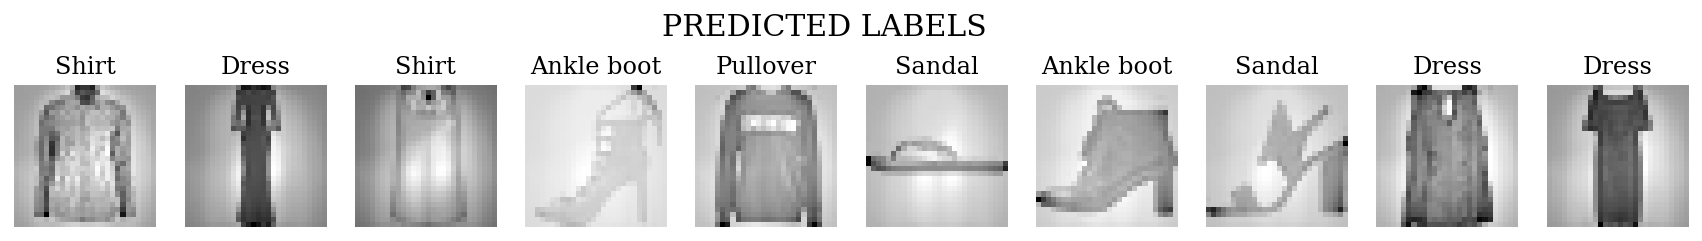

In [35]:
#Predicted answers (y_pred)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_pred[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.suptitle('PREDICTED LABELS',y=0.7,fontsize=15)
plt.show()

Not too shabby!

## Autoencoders <a class="anchor" id="three"></a>

**Autoencoders are neural networks that copy their input to their output, but after passing the data through a compression bottleneck**. For example if there are 28x28 = 784 inputs, there will also be 784 outputs, but there will be one or more (odd, but symmetric) hidden layers with fewer neuron than that.

***Therefore the encoder layers learn a compressed representation of the data, with the decoder layers transforming the encodings back to the full data dimensionality.*** 

For example see 

![autoencoder structure](https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

from
https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

You can think of this as doing **PCA with a neural network** -- breaking our data down into the only the most important features that we actually *need* (finding the intrinsic dimensionality). In fact, if the network uses only linear (or no) activation functions and $L2$ cost function, then we have exactly PCA.  

How might this be useful?  Well, for example we can use it to reconstruct MNIST digits that have had noise added to them:

![autoencoder example](https://miro.medium.com/max/1400/1*SxwRp9i23OM0Up4sEze1QQ@2x.png)

More exciting possibilities are: 

- Using autoencoders for "**unsupervised pretraining**". For example you have data that is only partially labeled (at least not enough to do traditional supervised classification).  We can train an autoencoder on the full data set, then used the encoder part as the base of a regular neural network that is trained on the labeled data that we do have. This is found to be a much more efficient way of initializing weights and biases than starting from random, because you are "cheating" a bit by already figuring out some of the data structure using the autoencoder. See Geron Figure 17.6.
- **[Anomaly detection](https://scikit-learn.org/stable/modules/outlier_detection.html)** (remember the old problem of figuring out if two samples are extracted from the same distribution?) e.g. https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6 and https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea. See also
https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/ and 
https://towardsdatascience.com/autoencoder-neural-network-for-anomaly-detection-with-unlabeled-dataset-af9051a048.

### Variational Autoencoders

More common in astronomy are **variational autoencoders**, partly because the "latent space" (i.e. the compressed representation of the data) that results from a standard autoencoder doesn't necessarily map continuously to the data (e.g., if your training data don't represent the possibilities or span of the full data space). 

We won't go into detail, just realize that these are something that you might try if you were otherwise going to try an autoencoder to tackle your problem. **Instead of the encoder layers compressing the data down to a single point in the "latent space", it is mapped to a continuous distribution** (imagine if PCA gave you a probabilistic compression). The prior on this continuous distribution is a Gaussian with mean and variance. ***Therefore the intuition for variational autoencoders is that the mean vector centers the average encoding of the data point, while the variance samples around this average encoding.*** This allows the encoding and decoding to interpolate much more smoothly across the training data. 

![Ivezic Figure 9.21](https://www.astroml.org/_images/fig_vae_1.png)


This one below is an example of a variational autoencoder trained on SDSS spectra using `pytorch`.

I won't cover this in class because there won't be time, but I'll leave it here for you as a further worked out example


In [124]:
from astroML.datasets import sdss_corrected_spectra
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

# Fetch and prepare the data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

# normalize spectra by integrated flux and subtract out mean, for easier training
spectranorms = np.mean(spectra, axis=1)
normedspectra = spectra / spectranorms[:, None]
meanspectrum = np.mean(normedspectra, axis=0)
normedspectra -= meanspectrum[None, :]

# split data into 3:1 train:test
torch.manual_seed(802)  # seed used for book figure
dataset = torchdata.TensorDataset(torch.tensor(normedspectra))
trainnum = normedspectra.shape[0] // 4 * 3
traindata, testdata = torchdata.random_split(dataset, 
                                             [trainnum, normedspectra.shape[0] - trainnum])
traindataloader = torchdata.DataLoader(traindata, batch_size=128, shuffle=True)

Now define the structure of the variational autoencoder. 
- In the top block you can see that the first layer reduces the $1000$-D input down to $250$.
- We then pass to a $2$D mean and variance layer from which the compressed "latent" parameters can be probabilistically drawn. This means that we compressing down from a 1000 flux channels to a 2D compressed representation.
- The decoding layers decompress the sampled latent parameters and scale back up to the full 1000 flux channel dimensions.

In [125]:
# define structure of variation autoencoder
class VAE(nn.Module):
    def __init__(self, nhidden=250):
        super(VAE, self).__init__()

        # encoding layers
        self.encode_fc = nn.Linear(1000, nhidden)
        self.mu        = nn.Linear(nhidden, 2)
        self.logvar    = nn.Linear(nhidden, 2)

        # decoding layers
        self.decode_fc = nn.Linear(2, nhidden)
        self.output    = nn.Linear(nhidden, 1000)

    def encode(self, x):
        h = F.relu(self.encode_fc(x))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h = F.relu(self.decode_fc(z))
        return self.output(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

The loss is a modified version of the usual MSE, where we use the **Kullback-Leibler divergence** to asses how close the latent parameter distribution is to a Gaussian. 

In [126]:
# add KL divergence to loss function
def VAEloss(criterion, recon_x, x, mu, logvar):
    return criterion(recon_x, x) - 0.5 * torch.sum(1 + logvar - 
                                                   mu.pow(2) - 
                                                   logvar.exp())

Another large block that is essentially just training the network.

In [127]:
def train_model():
    model = VAE()
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           verbose=True, 
                                                           patience=5, 
                                                           threshold=1e-3)

    min_valid_loss = float('inf')
    badepochs = 0
    for t in range(1000):
        train_loss = 0
        for i, databatch in enumerate(traindataloader, 0):
            specbatch = databatch[0]
            optimizer.zero_grad()
            recon, mu, logvar = model(specbatch)
            loss = VAEloss(criterion, recon, 
                           specbatch, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        with torch.no_grad():
            testspec = testdata[:][0]
            recon, mu, logvar = model(testspec)
            valid_loss = VAEloss(criterion, recon, 
                                 testspec, mu, logvar)
            if t % 10 == 0:
                print('Epoch %3i: train loss %6.1f validation loss %6.1f' % \
                        (t, train_loss / len(traindata), valid_loss / len(testdata)))
            # stop training if validation loss has not fallen in 10 epochs
            if valid_loss > min_valid_loss*(1-1e-3):
                badepochs += 1
            else:
                min_valid_loss = valid_loss
                badepochs = 0
            if badepochs == 10:
                print('Finished training')
                break
        scheduler.step(valid_loss)
    return model

In [128]:
print(model)

Let's train this thing! (Takes less than a minute)

In [129]:
model = train_model()

Epoch   0: train loss 2276.2 validation loss 1259.7
Epoch  10: train loss  423.4 validation loss  405.2
Epoch  20: train loss  233.2 validation loss  309.6
Epoch  30: train loss  181.3 validation loss  281.8
Epoch  40: train loss  149.2 validation loss  265.0
Epoch  50: train loss  125.7 validation loss  255.5
Epoch  60: train loss  111.5 validation loss  240.4
Epoch  70: train loss  101.1 validation loss  235.0
Epoch  80: train loss   94.0 validation loss  228.6
Epoch  90: train loss  157.4 validation loss  222.6
Epoch 100: train loss   81.6 validation loss  216.3
Epoch 110: train loss   77.4 validation loss  213.0
Epoch 120: train loss   71.7 validation loss  210.0
Epoch   130: reducing learning rate of group 0 to 1.0000e-05.
Epoch 130: train loss   75.7 validation loss  209.3
Finished training


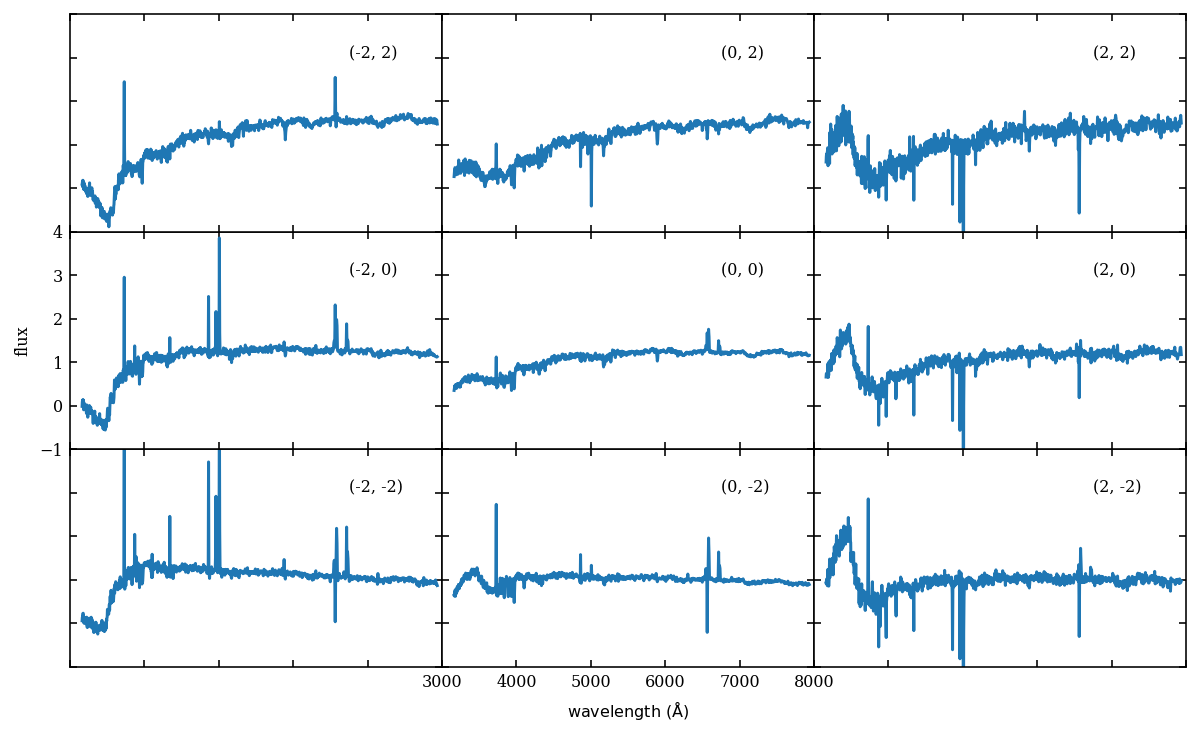

In [130]:
# plot results
with torch.no_grad():
    # sort latent parameters from most constrained to least constrained
    testspec = dataset[:][0]
    recon, mu, logvar = model(testspec)
    zorder = np.argsort(np.mean(logvar.numpy(), axis=0))

    fig = plt.figure(figsize=(10, 6))
    fig.subplots_adjust(hspace=0, wspace=0)
    parvalues = [-2.,0.,2.]
    for i, z1 in enumerate(parvalues):
        for j, z2 in enumerate(parvalues):
            # get z1 to vary left to right, z2 bottom to top
            ax = fig.add_subplot(3, 3, (2-j)*len(parvalues)+i+1)

            z = np.zeros((1,2), dtype=np.float32)
            z[0, zorder] = z1, z2 # set z1 is more constrained of the two latent parameters
            spectrum = model.decode(torch.tensor(z))
            ax.plot(wavelengths, meanspectrum+spectrum.numpy()[0,:])
            ax.text(6750, 3, '(%i, %i)' % (z1,z2))

            ax.set_xlim(3000, 8000)
            ax.set_ylim(-1, 4)

            if i == 0 and j == 1:
                ax.set_ylabel('flux')
            else:
                ax.yaxis.set_major_formatter(plt.NullFormatter())
            if j == 0 and i == 1:
                ax.set_xlabel(r'${\rm wavelength\ (\AA)}$')
            else:
                ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.show()

The spectra above are generated from our variational autoencoder. As mentioned, the encoder was limited to two components (2D compressed latent space). As neurons are progressively activated in the latent space, we generate a smooth transition from spectra consistent with quiscent to star-forming galaxies. The numbers in each panel indicate the activation value of the two neurons in the latent space.

## Generative Adversarial Networks (GANs) <a class="anchor" id="four"></a>

Finally here's a brief discussion on GANs, which are one of latest innovation in deep learning.

GANs are pure evil, see https://www.unrealperson.com/.

But they are also brilliant, incredibly useful, and relatively new ([Goodfellow et al 2014](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)). The idea builds logically on autoencoders.
1. We have a generator (like the decoder part of an autoencoder) that can produce fake data (e.g., an image). 
2. Then we have a discriminator (a standard binary classifier) that tries to distinguish fake data from real.  
3. Then the generator learns to produce more and more accurate images to trick the discriminator -- without ever seeing any real images -- it just has the feedback from the discriminator.
4. We are pitting artifical neural networks against themselves to make them stronger. What could possibly go wrong, right?

![](https://learning.oreilly.com/library/view/java-deep-learning/9781788997454/assets/2cf8b4f1-7163-4af1-aa4b-6066329d554a.png)

For more, see
https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29

Astronomy has seen some interesting uses of autoencoders and GANs in recent years.  For example:
    
- https://arxiv.org/abs/1702.00403    
- https://www.aanda.org/articles/aa/full_html/2017/07/aa30240-16/aa30240-16.html

More generally, these are some applications of deep networks to GW detection (my main interest):

- https://arxiv.org/pdf/1711.03121.pdf
- https://arxiv.org/pdf/1812.02183.pdf

I'm afraid that is all the time we can spend on deep learning. One of the coolest thing I didn't have time to talk about are the so-called **Masked Autoregressive Flows**, introduced by [Papamakarios et al (2017)](https://arxiv.org/abs/1705.07057). MAF are the latest answer to the long-standing problem of density estimation (remember how tricky it can be to choose the number of bins? Now tackle that problem with the full power of deep learning!). In my research field: [Wong et al 2020](https://arxiv.org/abs/2002.09491)

I'm not saying that you are ready for a data science job after these two lectures, but you now know more than the majority of astrophysicists that talk about neural networks, and you have used the two big codes. There are tons of useful videos, tutorials, and online courses that can take you further if you are interested in deep learning.

Another tool you may be interested in: https://astronn.readthedocs.io/en/latest/index.html

## Time to get your hands dirty. Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

[My solution](https://github.com/dgerosa/astrostatistics_bicocca_2023/blob/main/solutions/S20_galaxyquasar2.ipynb)

----

# That's all folks!

![](https://imgs.xkcd.com/comics/data_trap.png)

Credit: [xkcd 2582](https://xkcd.com/2582/)

## Extra material

The repository has two additional lectures on time series data which, unfortunately, I didn't have time to cover. 

## Feedback!

Please remember my feedback form

https://forms.gle/2xPGGx3WgJHCYtnf9

## Many ideas for Master's thesis projects with me and the rest of my research group

Here we are: https://davidegerosa.com/group/

Here are the amazing folks I'm working with. Come and have a chat, we are always looking for new friends!

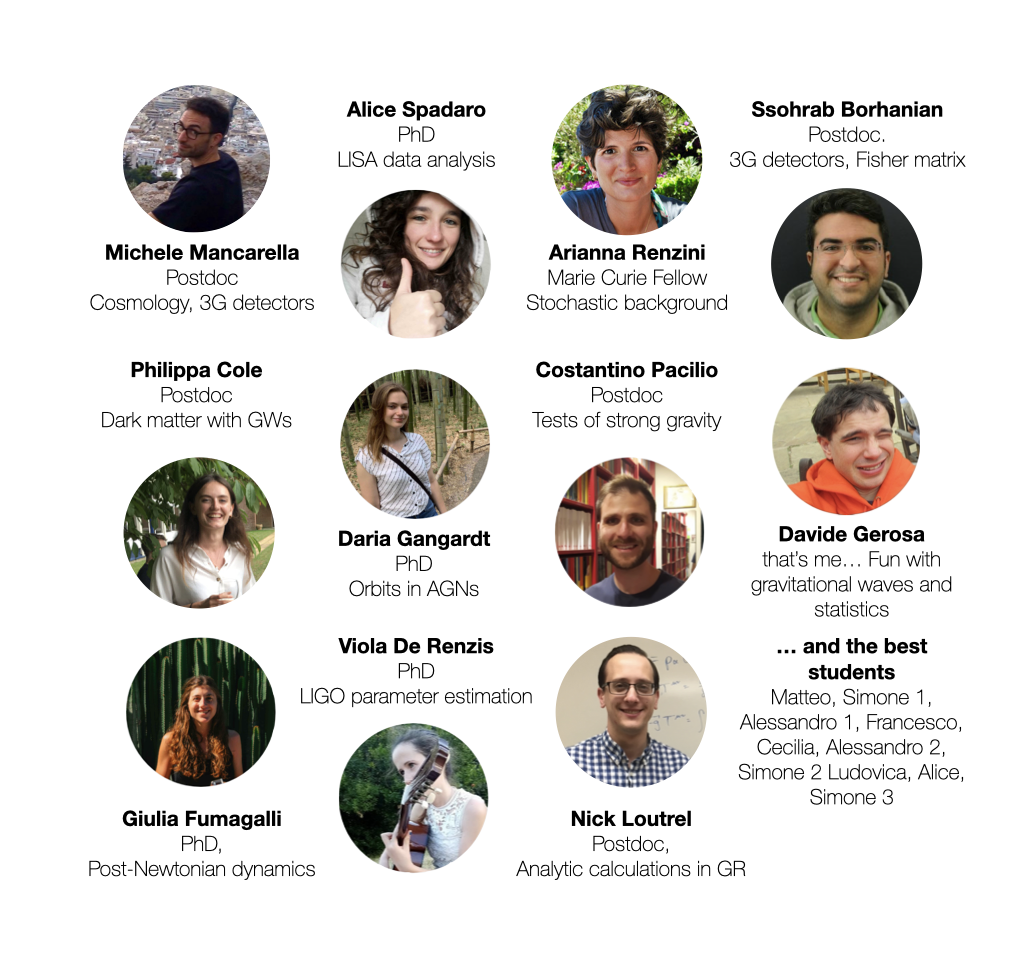